In [1]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
from jax import jit, grad
import jax.numpy as jnp
from math import prod

# 1 - Layer compilation

In [5]:
reg = jqtc.Register([2,4,3])
cirq = jqtc.Circuit.create(reg, layers=[])

X = jqtc.Gate.create(
    2, 
    name="X",
    gen_U = lambda params: jqtc.sigmax(),
    num_modes=1
)

D = jqtc.Gate.create(
    3, 
    name="D",
    params={"alpha": 1},
    gen_U = lambda params: jqtc.displace(3,params["alpha"]),
    num_modes=1
)

op_X = jqtc.Operation.create(X, 0, reg)
op_D = jqtc.Operation.create(D, 2, reg)

layer = jqtc.Layer.create([op_D, op_X])

layer

Layer(operations=[Operation(gate=D, indices=[2], register=Register(dims=[2, 4, 3])), Operation(gate=X, indices=[0], register=Register(dims=[2, 4, 3]))], _unique_indices=[0, 2])

In [6]:
U = layer.gen_U()

In [7]:
jnp.max(jnp.abs((U - (jqt.sigmax() ^ jqt.identity(4) ^ jqt.displace(3,1))).data))

Array(0., dtype=float64)

# 2 - Simulating a Circuit

In [8]:
reg = jqtc.Register([2,4,3])
cirq = jqtc.Circuit.create(reg, layers=[])

X = jqtc.Gate.create(
    2, 
    name="X",
    gen_U = lambda params: jqtc.sigmax(),
    num_modes=1
)

D = jqtc.Gate.create(
    3, 
    name="D",
    gen_U = lambda params: jqtc.displace(3,1),
    num_modes=1
)

op_X = jqtc.Operation.create(X, 0, reg)
op_D = jqtc.Operation.create(D, 2, reg)

layer1 = jqtc.Layer.create([op_X, op_D])

Z = jqtc.Gate.create(
    2, 
    name="Z",
    gen_U = lambda params: jqtc.sigmaz(),
    num_modes=1
)

op_Z = jqtc.Operation.create(Z, 0, reg)

layer2 = jqtc.Layer.create([op_Z])

cirq.append_layer(layer1)
cirq.append_layer(layer2)

In [9]:
initial_state = (jqt.basis(2,0) + jqt.basis(2,1)) ^ jqt.basis(4,0) ^ jqt.basis(3,0)
initial_state = initial_state.unit()
res = jqtc.simulate(cirq, initial_state)

In [12]:
plusstate = (jqt.basis(2,0) -jqt.basis(2,1)).unit()

jqt.ptrace(res.results[2][0], 0) - plusstate.to_dm()

Quantum array: dims = [[2], [2]], shape = (2, 2), type = oper
Qarray data =
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

# 3 - Simpler circuit writing

In [2]:
N = 10
beta = 2
reg = jqtc.Register([2,N])
cirq = jqtc.Circuit.create(reg, layers=[])
cirq.append(jqtc.X(),0)
cirq.append(jqtc.CD(N, beta),[0,1])

In [3]:
initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
res = jqtc.simulate(cirq, initial_state)

Text(0, 0.5, 'Im[α]')

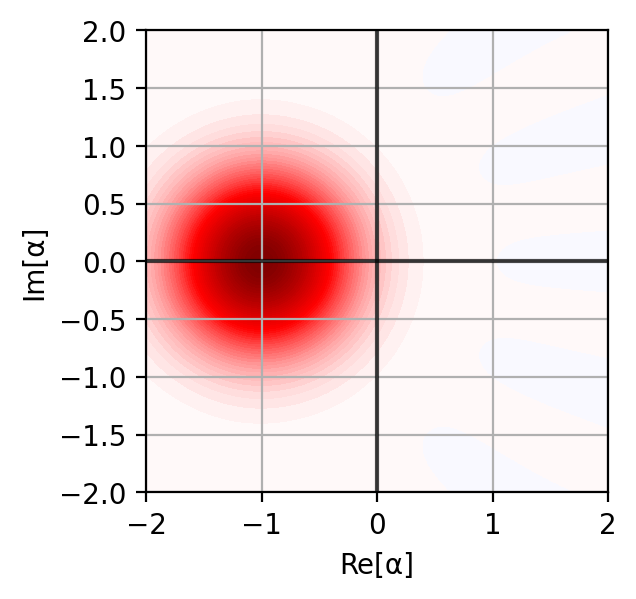

In [8]:
pts = jnp.linspace(-2,2, 101)
ax = jqt.plot_wigner(jqt.ptrace(res[-1][-1],1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

# 4 - optimize

In [9]:
@jit
def metric(beta):
    N = 10
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])
    cirq.append(jqtc.X(),0)
    cirq.append(jqtc.CD(N, beta),[0,1])
    
    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state)

    final_state = res[-1][-1]
    target_state = jqt.basis(2,1) ^ (jqt.displace(N, -1.5) @ jqt.basis(N,0))
    return jnp.real((final_state.dag() @ target_state).data[0][0])
    

In [11]:
grad(metric)(1.5*2)

Array(-1.11022302e-16, dtype=float64, weak_type=True)